# Generating Gamma Surfaces & Stacking Fault

Gamma surfaces (also called generalised stacking faults) and stacking faults are forms of crystal defects formed by sliding two slabs of a crystal against each other along a given plane. Often, these defects have metastable states (also called stacking faults), which can exist at grain boundaries or between two partial dislocations. Here, we deal with the full pathway from a complete crystal, sliding through any metastable points until we return back to the perfect crystal again. 

For a stacking fault, the slabs are moved along a single line, whereas for gamma surfaces this is the full plane (hence generalised stacking fault). `matscipy.gamma_surface` provides two classes - `GammaSurface` and `StackingFault` - in order to model these systems, including utility methods for relaxing and plotting the associated potential energy surfaces.

## Stacking Faults for a Specific Dislocation
When modelling systems of dissociated dislocations connected by a stacking fault, it can be useful to see the stacking fault in isolation. To do this, we will use `matscipy.gamma_surface.StackingFault` to model the stacking fault associated with the dissociated `matscipy.dislocations.DiamondGlideScrew` dislocation in Carbon. 

We will first use a potential by  to obtain reasonable guesses for a lattice parameter and elastic constants, and take a look at the dissociated `DiamondGlideScrew` dislocation:

In [1]:
from matscipy.dislocation import DiamondGlideScrew, get_elastic_constants
from matscipy.gamma_surface import StackingFault
from matscipy.calculators.manybody.explicit_forms.tersoff_brenner import TersoffBrenner, Brenner_PRB_42_9458_C_I
from matscipy.calculators.manybody import Manybody
from visualisation import show_dislocation, show_stacking_fault

calc = Manybody(**TersoffBrenner(Brenner_PRB_42_9458_C_I))

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=calc, symbol="C")
print(f"alat = {alat}")
C_screw = DiamondGlideScrew(alat, C11, C12, C44, symbol="C")

C_screw_bulk, C_screw_dislo = C_screw.build_cylinder(radius=20, partial_distance=10)

print(C_screw.glide_distance_dimensionless)

show_dislocation(C_screw_dislo, 
                 diamond_structure=True, # bonds make it a bit easier to see the structure
                 scale=0.3, add_bonds=True, 
                 partial_distance=10 * C_screw.glide_distance, 
                 d_name="1/6<112> 30 degree partial screw") 


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:45:11      -71.023173*      21.6660
FIRE:    1 11:45:11      -70.778252*      27.1719
FIRE:    2 11:45:11      -72.074178*       7.7128
FIRE:    3 11:45:11      -71.810725*      12.8423
FIRE:    4 11:45:11      -71.909801*      11.1435
FIRE:    5 11:45:11      -72.057595*       7.8693
FIRE:    6 11:45:11      -72.174468*       3.3124
FIRE:    7 11:45:11      -72.190180*       2.0030
FIRE:    8 11:45:11      -72.190836*       1.9252
FIRE:    9 11:45:11      -72.192047*       1.7727
FIRE:   10 11:45:11      -72.193627*       1.5519
FIRE:   11 11:45:11      -72.195333*       1.2717
FIRE:   12 11:45:11      -72.196904*       0.9434
FIRE:   13 11:45:11      -72.198103*       0.5801
FIRE:   14 11:45:11      -72.198751*       0.1961
FIRE:   15 11:45:11      -72.198716*       0.2336
FIRE:   16 11:45:11      -72.198718*       0.2309
FIRE:   17 11:45:11      -72.198724*       0.2256
FI

NGLWidget()

To model just the stacking fault, we can call `StackingFault` with just the lattice constant, crystalstructure (one of "fcc", "bcc", "diamond"), the chemical symbol, and the kind of dissociated dislocation, and use the function `StackingFault.generate_images()` to generate the fault images.

In [2]:
fault = StackingFault(alat, DiamondGlideScrew, symbol="C")
fault.generate_images(n=16) # Generate 16 images along the pathway
show_stacking_fault(fault.images)

Now that we have the images generated, we can use the calculator by [D. Holland and M. Marder](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.80.746) to relax the images, and look at the energy barrier associated with forming the stacking fault.

There are many things to consider when measuring stacking fault energy densities, and there are many conventions found in literature. Here, we only look at relaxations of these systems, but there are still many parameters to explore. We should consider whether the system should be vacuum terminated, how far apart the periodic images of the stacking fault should be, what constraints to add to the system, and whether there could be another plane with the same normal that could be more energetically favourable.

This is a lot to consider, so we will explore the effect of tuning these parameters now.

### Parameterising stacking fault image generation

The default behaviour of `StackingFault.generate_images()` is to build as small of a cell as possible, based on the output of either `ase.lattice.cubic` (when `a` is a lattice parameter), or `ase.build.bulk`. This is likely to suffer from finite size effects for most systems, so it may be useful to include more bulk between periodic images of a stacking fault. We may also wish to use the argument `vaccuum=5.0` to add $5\AA$ of vacuum between the faults, but we will ignore this for now..

In [3]:
# Re-running fault.generate_images() will just replace the images
fault.generate_images(
    n=16, # Still generate 16 images
    z_replications=3# Add copies of the bulk between stacking faults
)
show_stacking_fault(fault.images)


We can see that this gives a stacking fault with more bulk.
Next, let's relax the fault and look at the energy barrier.

### Relaxing stacking fault images

To relax the stacking fault images, we can use `StackingFault.relax_images`. Here, we have more choices to make, mainly through which constraints we apply to the images, which are controlled by the arguments `constrain_atoms` and `cell_relax`. As the name suggests, `constrain_atoms` adds atomic constraints, which restrict the atoms to only relax in the Z direction (towards or away from the stacking fault). The `cell_relax` argument allows the length of the cell in Z (`image.cell[2, 2]`) to be relaxed.

Here, we will stick with the defaults (`constrain_atoms=True, cell_relax=True`). We will then use `StackingFault.get_surface_energies()` to evaluate the energy barrier associated with the stacking fault.

NOTE: With stacking faults, we actually measure the energy __density__ (energy per unit area of the stacking fault), which is often expressed in $\text{eV/}\AA^2$ or in $\text{J/m}^2$. We return with $\text{eV/}\AA^2$ in `StackingFault.get_surface_energies()`.

In [4]:
fault.relax_images(calc)
Es = fault.get_surface_energies(calc)

Now that we have relaxed the images and found the energy barrier, we should see what the barrier looks like. One way of doing this is to use the inbuilt `StackingFault.plot_gamma_surface()` function:

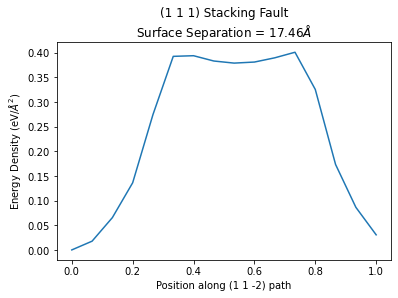

In [5]:
fault.plot_gamma_surface()

show_stacking_fault(fault.images)